# Explorative Data Analysis - CO2 Emissions

## Objective
In this notebook, the CO₂ emissions based on the fuel consumption of newly for sale vehicles in Canada in 2025 are analyzed. The main objective is to identify the characteristics of vehicles that have the greatest impact on the vehicle emissions. Another objective is to identify correlations between features from which new information can be derived. 

## Data
The dataset used in this notebook is publisehd in: https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64/resource/d589f2bc-9a85-4f65-be2f-20f17debfcb1

## Steps
The steps taken in this notebook:
- [Step 1](#step_1)
    : Importing Libraries and Dataset
- [Step 2](#step_2)
    : Dataset Informations + Data Quality
- [Step 3](#step_3)
    : CO2 Emissions and Rating    
- [Step 4](#step_4)
    : Car Manufacturers
- [Step 5](#step_5)
    : Vehicle Classes
- [Step 6](#step_6)
    : Number Cylinders and Engine Size   
- [Step 7](#step_7)
    : Fuel Type      
- [Step 8](#step_8)
    : Fuel Consumption          
- [Step 9](#step_9)
    : Machine Learning

## <a id="step_1">Step 1: Importing Libraries and Dataset</a>

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# ML Algorithm
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [2]:
# nrows is set to 967, since the csv file includes a describtion of the columns below the actual table, making it necessary to specify nrows to only include the table 
df = pd.read_csv(os.path.join('Datasets','d589f2bc-9a85-4f65-be2f-20f17debfcb1.csv'), header=[0,1], nrows=967)

## <a id="step_2">Step 2: Dataset Informations  + Data Quality</a>

The dataset contains model-specific fuel consumption and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada 

To understand the dataset, the csv file contains following explainations:

#### Model

- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase

#### Transmission	

- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual
- 3 – 10 = Number of gears

#### Fuel type

- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas

#### Fuel consumption

City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)

#### CO2 emissions

the tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving

#### CO2 rating

the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best)

#### Smog rating

the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best)


In [3]:
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
,2025,Acura,Integra A-SPEC,Full-size,1.5,4,AV7,Z,8.1,6.5,7.4,38,172,6,6
0,2025,Acura,Integra A-SPEC,Full-size,1.5,4,M6,Z,8.9,6.5,7.8,36,181,6,5
1,2025,Acura,Integra Type S,Full-size,2.0,4,M6,Z,11.1,8.3,9.9,29,230,5,5
2,2025,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,4
3,2025,Acura,MDX SH-AWD Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,13.8,11.2,12.4,23,291,4,4
4,2025,Acura,RDX SH-AWD,Sport utility vehicle: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,5


At first glance there seems to be a multiindex header witht the first row. Lets break the header up and fix that using the get_level_values function.

In [4]:
header = list(df.columns.get_level_values(0))
header

['Model year',
 'Make',
 'Model',
 'Vehicle class',
 'Engine size (L)',
 'Cylinders',
 'Transmission',
 'Fuel type',
 'City (L/100 km)',
 'Highway (L/100 km)',
 'Combined (L/100 km)',
 'Combined (mpg)',
 'CO2 emissions (g/km)',
 'CO2 rating',
 'Smog rating']

In [5]:
first_row = list(df.columns.get_level_values(1))
first_row

['2025',
 'Acura',
 'Integra A-SPEC',
 'Full-size',
 '1.5',
 '4',
 'AV7',
 'Z',
 '8.1',
 '6.5',
 '7.4',
 '38',
 '172',
 '6',
 '6']

All entries in the list are strings, a look at the column dtypes shows the need to change some of these values.

In [6]:
df.dtypes.astype(str).tolist()

['int64',
 'object',
 'object',
 'object',
 'float64',
 'int64',
 'object',
 'object',
 'float64',
 'float64',
 'float64',
 'int64',
 'int64',
 'int64',
 'int64']

In [7]:
first_row = [int(x) if i in {0, 5, 11, 12, 13, 14} else x for i, x in enumerate(first_row)]
first_row = [float(x) if i in {4, 8, 9, 10} else x for i, x in enumerate(first_row)]
first_row


[2025,
 'Acura',
 'Integra A-SPEC',
 'Full-size',
 1.5,
 4,
 'AV7',
 'Z',
 8.1,
 6.5,
 7.4,
 38,
 172,
 6,
 6]

First add the new row and reindex the dataframe so it shows up in the first row of the dataframe.

In [8]:
df.loc[-1] = first_row
df.index += 1
df.sort_index(inplace=True)

Then fix the header.

In [9]:
df.columns = header

Explore the dataset by looking at the overall information. 

In [10]:
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2025,Acura,Integra A-SPEC,Full-size,1.5,4,AV7,Z,8.1,6.5,7.4,38,172,6,6
1,2025,Acura,Integra A-SPEC,Full-size,1.5,4,M6,Z,8.9,6.5,7.8,36,181,6,5
2,2025,Acura,Integra Type S,Full-size,2.0,4,M6,Z,11.1,8.3,9.9,29,230,5,5
3,2025,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,4
4,2025,Acura,MDX SH-AWD Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,13.8,11.2,12.4,23,291,4,4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, 0 to 580
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            581 non-null    int64  
 1   Make                  581 non-null    object 
 2   Model                 581 non-null    object 
 3   Vehicle class         581 non-null    object 
 4   Engine size (L)       581 non-null    float64
 5   Cylinders             581 non-null    int64  
 6   Transmission          581 non-null    object 
 7   Fuel type             581 non-null    object 
 8   City (L/100 km)       581 non-null    float64
 9   Highway (L/100 km)    581 non-null    float64
 10  Combined (L/100 km)   581 non-null    float64
 11  Combined (mpg)        581 non-null    int64  
 12  CO2 emissions (g/km)  581 non-null    int64  
 13  CO2 rating            581 non-null    int64  
 14  Smog rating           581 non-null    int64  
dtypes: float64(4), int64(6), obj

As can be seen in the info, the dataset not a single NaN value in any column. So there is no need to apply any imputation methods to handle missing values.

Further, the dataset contains 5 categorical columns that need to be encoded when training most machine learning algorithms. The remaining columns are containing integers and floats. The variables that are suitable for use as target variables when training an algorithm, such as CO₂ emissions or smog, are available as integers.

In [12]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

print(f'Number of duplicated columns: {df.transpose().duplicated().sum()}')

Number of duplicated rows: 0
Number of duplicated columns: 0


There are no duplicated rows or columns in the dataset, that may need to be removed in the data preprocessing step before training a machine learning algorithm.

In [13]:
df.var(numeric_only=True)

Model year                 0.000000
Engine size (L)            1.527864
Cylinders                  3.393744
City (L/100 km)           12.023005
Highway (L/100 km)         5.006260
Combined (L/100 km)        8.151738
Combined (mpg)            69.698647
CO2 emissions (g/km)    4382.099869
CO2 rating                 1.845190
Smog rating                1.556615
dtype: float64

There is one constant columns in the dataset, which is the year, which is left in the dataset.

In [14]:
# df.describe()

## <a id="step_3">Step 3: CO2 Emissions and Rating</a>

To understand more about the target variable, the CO2 emissions, and the CO2 Rating, which should correlate negatively with the CO2 emissions, the distribution and correlation of these variables is explored. The higher the emissions the lower should be the rating. 

In [15]:
df['CO2 emissions (g/km)']

0      172
1      181
2      230
3      263
4      291
      ... 
576    205
577    223
578    213
579    212
580    244
Name: CO2 emissions (g/km), Length: 581, dtype: int64

<Axes: xlabel='CO2 emissions (g/km)', ylabel='Count'>

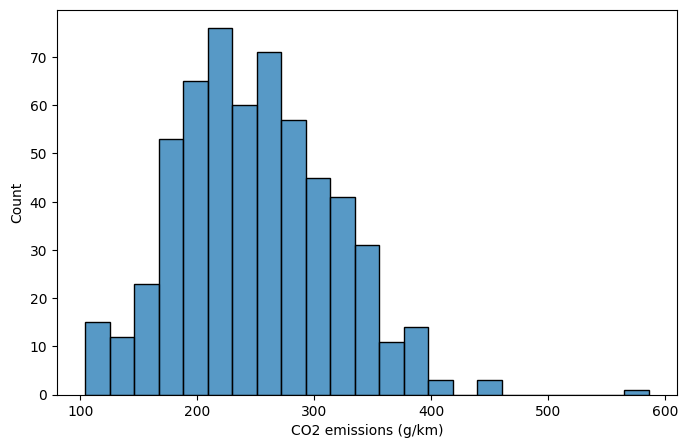

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='CO2 emissions (g/km)')

In [17]:
df['CO2 rating'].value_counts()

CO2 rating
5    179
4    161
6     92
3     67
7     35
2     25
8     15
1      7
Name: count, dtype: int64

<Axes: xlabel='CO2 rating', ylabel='Count'>

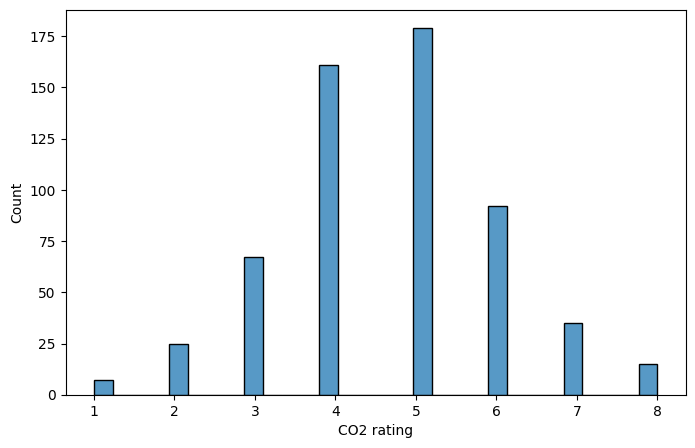

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='CO2 rating')

In [19]:
corr = df[['CO2 emissions (g/km)', 'CO2 rating']].corr()
corr

,CO2 emissions (g/km),CO2 rating
CO2 emissions (g/km),1.000000,-0.967185
CO2 rating,-0.967185,1.000000


As the correlation matrix shows, the CO2 Rating has a strongly negative correlation with the CO2 emissions, as expected. Further, the distribution of ratings show that the CO2 Rating variable is highly imbalanced with strongly varying numbers of occurring frequencies

## <a id="step_4">Step 4: Car Manufacturers</a>

Which manufacturers are present in the dataset?

In [20]:
df['Make'].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'BMW',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'Ferrari', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hyundai',
       'Infiniti', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus',
       'Lincoln', 'Mazda', 'Mercedes-Benz', 'MINI', 'Mitsubishi',
       'Nissan', 'Ram', 'Rolls-Royce', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype=object)

Are there different amount of Models per manufacturer in the dataset? If so, which manufacturers are represented more/less often represented due to the amount of different vehicles included? 

Text(0, 0.5, 'Count')

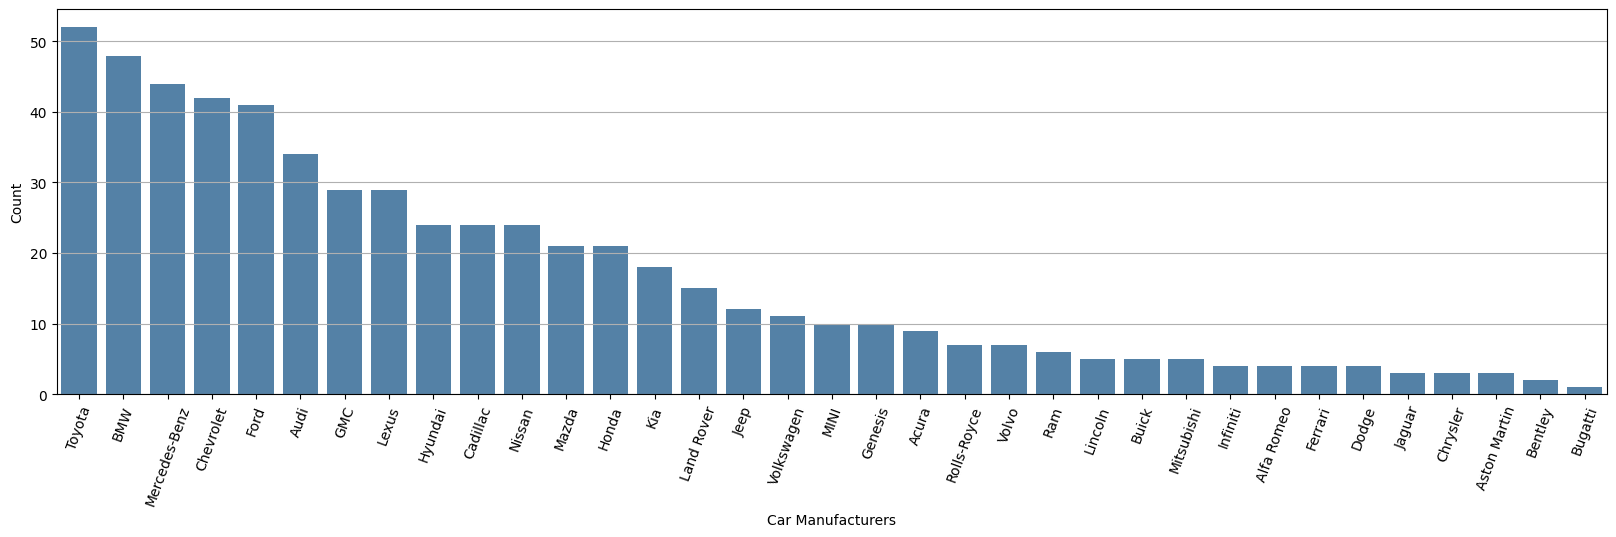

In [21]:
manufacturers_counts = df['Make'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_counts, x=manufacturers_counts['Make'], y=manufacturers_counts[manufacturers_counts.columns[1]], color='steelblue')
plt.xlabel('Car Manufacturers')
plt.ylabel('Count')

The most models are from Toyota, followed by BMW and Mercedes-Benz. On the fourth and fifth place are the US-manufacturers Chevrolet and Ford.

#### Average CO2 emissions per manufacturer 

Text(0.5, 0, 'Car Manufacturers')

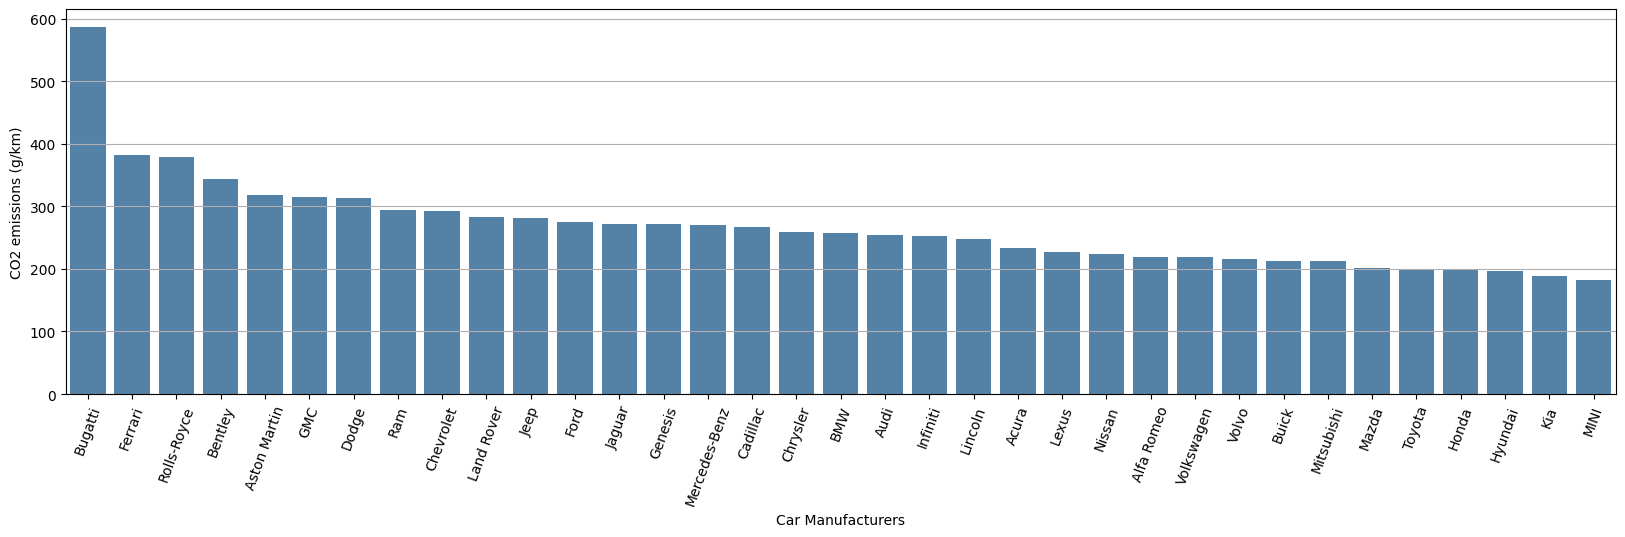

In [22]:
manufacturers_CO2 = df.groupby('Make')['CO2 emissions (g/km)'].mean().reset_index(drop=False).sort_values(by='CO2 emissions (g/km)', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_CO2, x=manufacturers_CO2['Make'], y=manufacturers_CO2['CO2 emissions (g/km)'], color='steelblue')
plt.xlabel('Car Manufacturers')

On average, the vehicles by the car manufacturers 'Bugatti', 'Ferrari' and 'Rolls-Royce' emit the most CO2 (g/km). That is expected since Bugatti and Lamborghini are super sportscar producer and rolls royce also mostly has very heavy cars with a lot of power. Let's check for these three manufacturers the number of cylinders and the engine sizes in relation to the other manufacturers.

<Axes: xlabel='Cylinders', ylabel='Engine size (L)'>

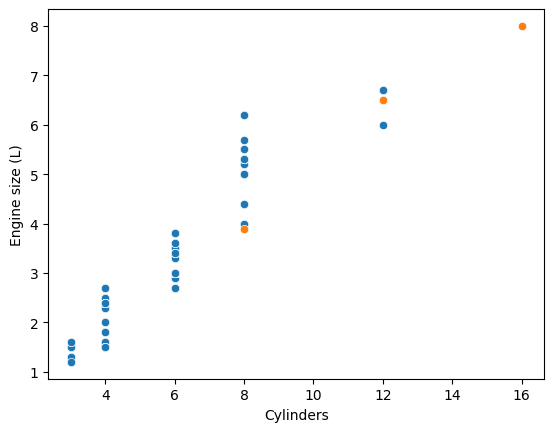

<Figure size 2000x500 with 0 Axes>

In [23]:
fig, ax = plt.subplots()
plt.figure(figsize=(20,5))
sns.scatterplot(data=df, x='Cylinders', y='Engine size (L)', ax=ax)
sns.scatterplot(data=df[df["Make"].str.contains("Bugatti|Ferrari|Rolls Royce")], x='Cylinders', y='Engine size (L)', ax=ax)

In [24]:
df[(df["Make"].str.contains("Bugatti|Ferrari|Rolls Royce", na=False)) & (df['Cylinders'] == 8)]

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
182,2025,Ferrari,Roma Spider,Minicompact,3.9,8,AM8,Z,13.9,10.5,12.4,23,290,4,5


The models of these manufacturers are in the higher spectrums of the cylinder numbers and engine sizes, although one model (8 Cylinders and 3.9L Engine Size) is in the midfield of the data, which is the Ferrari Roma Spider.

The disitribution of CO2 emissions of the different manufacturers gives an overview over these outliers for all manufacturers

Text(0.5, 0, 'Car Manufacturers')

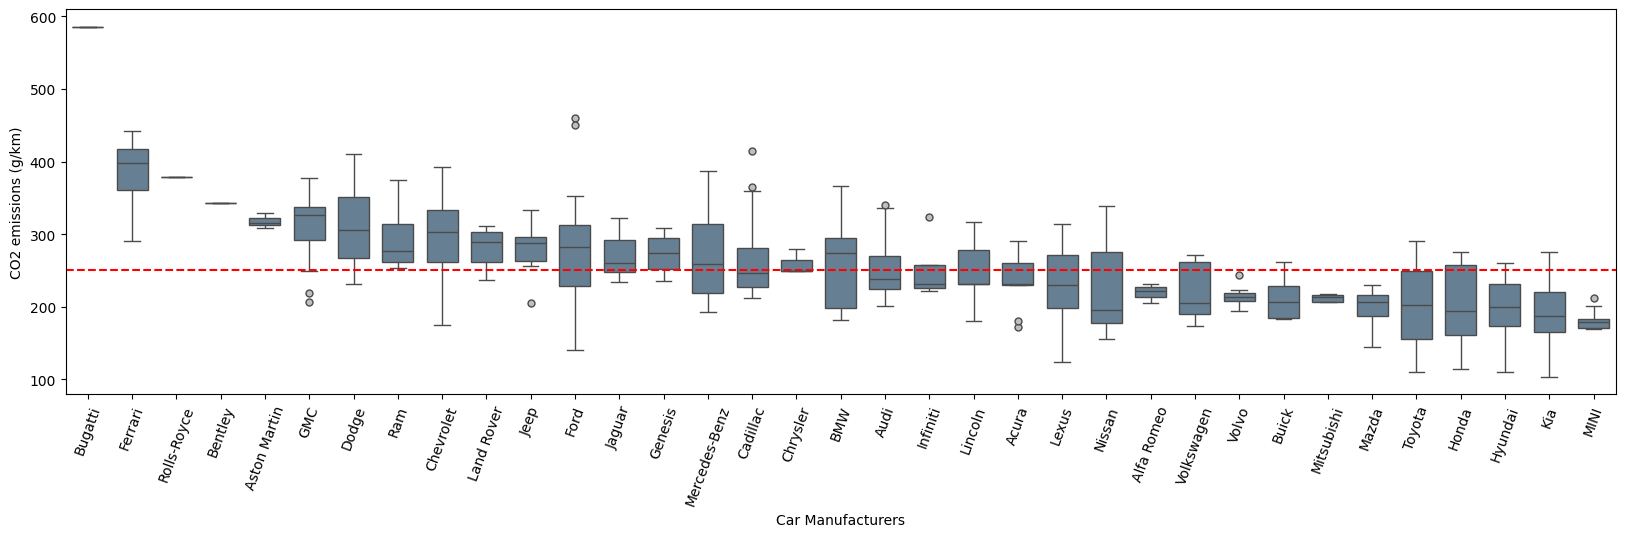

In [25]:
manufacturers_order = df.groupby('Make')['CO2 emissions (g/km)'].mean().reset_index(drop=False).sort_values(by='CO2 emissions (g/km)', ascending=False)['Make'].values
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')
sns.boxplot(data=df, x=df['Make'], y=df['CO2 emissions (g/km)'], color='steelblue', order=manufacturers_order, width=0.7, linewidth=1, saturation=0.4, flierprops=flierprops)
plt.axhline(df['CO2 emissions (g/km)'].mean(),color='r', linestyle='dashed')
plt.xlabel('Car Manufacturers')

In [26]:
df[df['Make'] == 'Ford'].sort_values(by=['CO2 emissions (g/km)'], ascending=False)[:2]

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
211,2025,Ford,F-150 Raptor R 4X4,Pickup truck: Standard,5.2,8,AS10,Z,22.8,15.9,19.7,14,460,1,4
221,2025,Ford,Mustang GTD,Subcompact,5.2,8,AM8,Z,23.5,13.9,19.2,15,451,1,4


There are big outliers at Ford with very high CO2 emissions, which are the F-150 pickup truck and the Mustang GTD.

 ## <a id="step_5">Step 5: Vehicle Classes</a>

Which vehicle classes are present in the dataset?

In [27]:
df['Vehicle class'].unique()

array(['Full-size', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard', 'Compact', 'Mid-size',
       'Minicompact', 'Two-seater', 'Subcompact', 'Station wagon: Small',
       'Station wagon: Mid-size', 'Pickup truck: Standard', 'Minivan',
       'Pickup truck: Small'], dtype=object)

Are there different amount of vehicle classes in the dataset? If so, which classes are represented more/less often represented due to the amount of different vehicles included? 

Text(0, 0.5, 'Count')

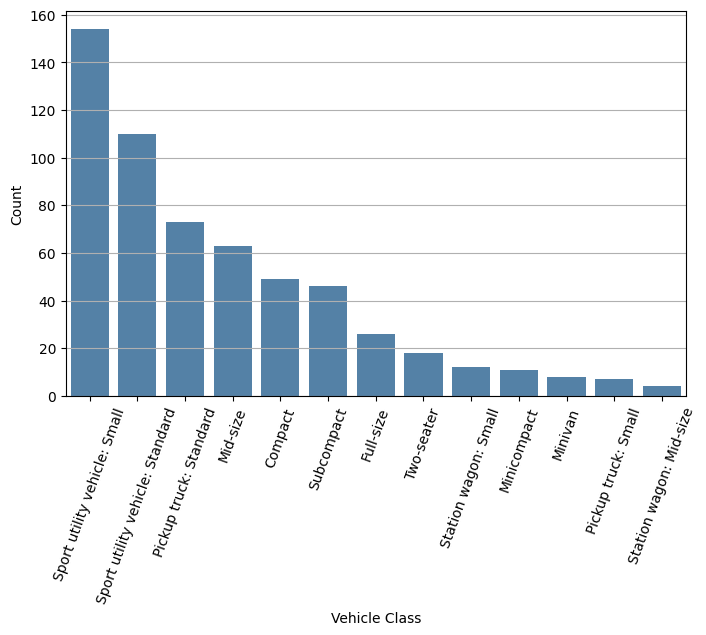

In [28]:
vehicleclass_counts = df['Vehicle class'].value_counts().reset_index(drop=False)
plt.figure(figsize=(8,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_counts, x=vehicleclass_counts['Vehicle class'], y=vehicleclass_counts[vehicleclass_counts.columns[1]], color='steelblue')
plt.xlabel('Vehicle Class')
plt.ylabel('Count')

Sport utility vehicles are the most models listet followed by normal-sized pickup trucks.

#### Average CO2 emissions per vehicle class 

Text(0.5, 0, 'Vehicle class')

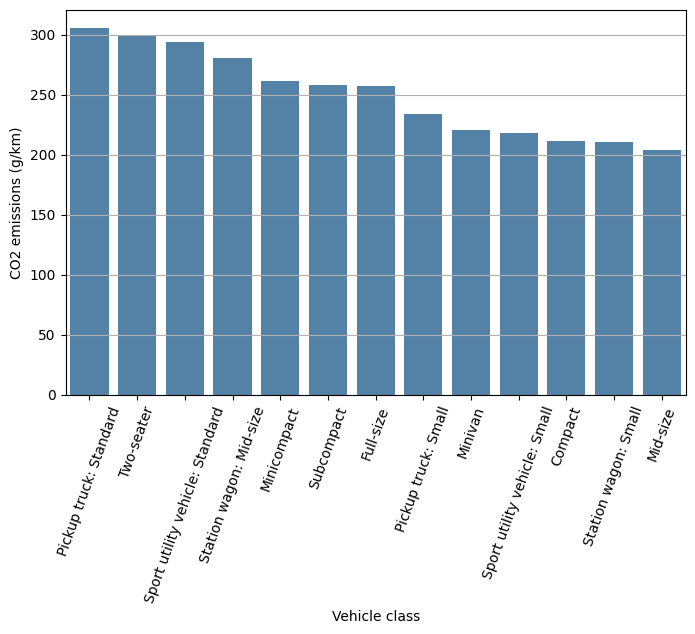

In [29]:
vehicleclass_CO2 = df.groupby('Vehicle class')['CO2 emissions (g/km)'].mean().reset_index(drop=False).sort_values(by='CO2 emissions (g/km)', ascending=False)
plt.figure(figsize=(8,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_CO2, x=vehicleclass_CO2['Vehicle class'], y=vehicleclass_CO2['CO2 emissions (g/km)'], color='steelblue')
plt.xlabel('Vehicle class')

The standard-sized pickup trucks are the ones with the most CO2 emissions on average.

#### Vehicle Classes of manufacturers

In [30]:
vehicleclasses_per_manufacturer = {}
for manufacturer in df['Make'].unique():
    unique_vehicleclasses = df[df['Make']==manufacturer]['Vehicle class'].unique()
    vehicleclasses_per_manufacturer[manufacturer] = list(unique_vehicleclasses)

In [31]:
df_vehicleclasses_per_manufacturer = pd.DataFrame(columns=df['Vehicle class'].unique())
for key, value in vehicleclasses_per_manufacturer.items():
    vehicleclasses_row = [1 if class_ in value else 0 for class_ in df['Vehicle class'].unique()]
    df_vehicleclasses_per_manufacturer.loc[key] = vehicleclasses_row
df_vehicleclasses_per_manufacturer = df_vehicleclasses_per_manufacturer.astype(int)

Text(209.1222222222222, 0.5, 'Car Manufacturer')

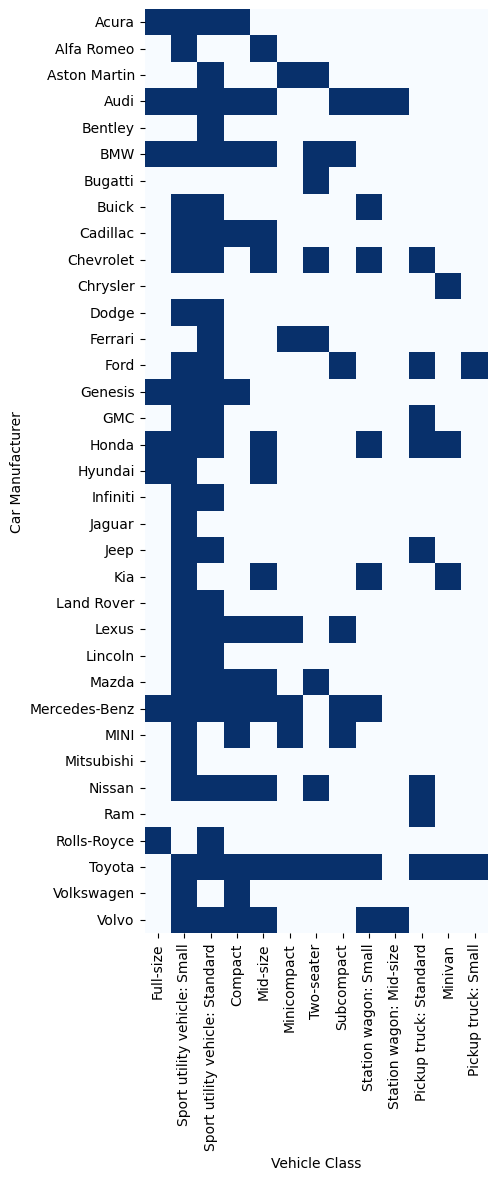

In [32]:
plt.figure(figsize=(8,12))
sns.heatmap(df_vehicleclasses_per_manufacturer, cmap="Blues", cbar=False, square=True)
plt.xlabel('Vehicle Class')
plt.ylabel('Car Manufacturer')

While sport utility vehicles are produced by almost all manufacturers, standard pickup trucks are only produced by a few, even though they are the third most present vehicle class.

## <a id="step_6">Step 6: Number Cylinders and Engine Size</a>

In [33]:
df['Cylinders'].unique()

array([ 4,  6,  8, 16,  3, 12])

Text(0, 0.5, 'Count')

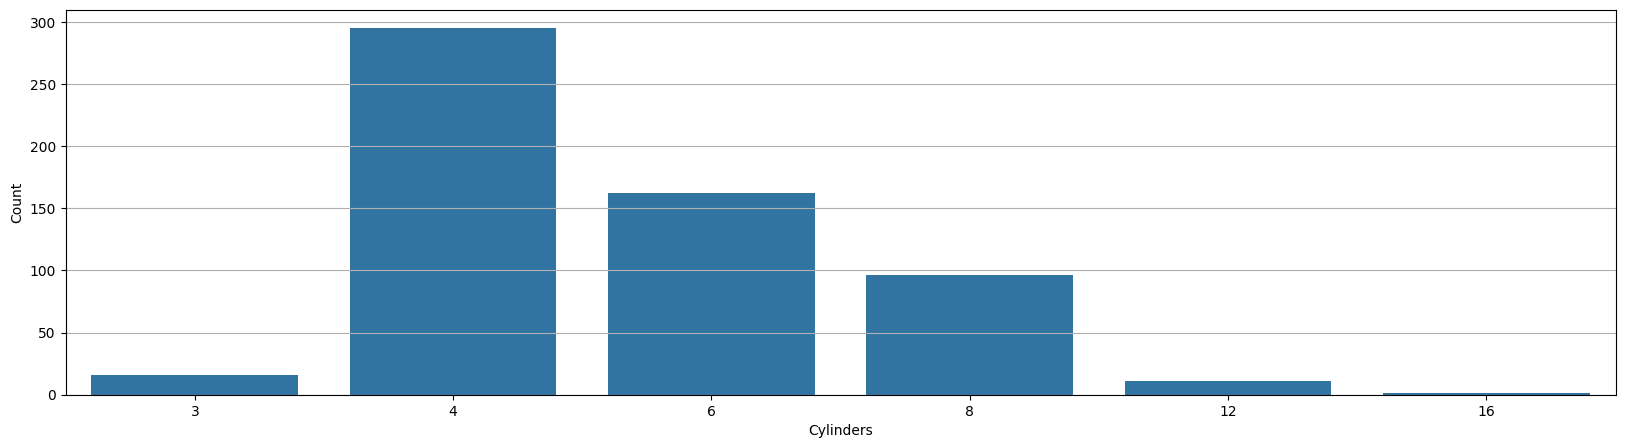

In [34]:
cylinders_counts = df['Cylinders'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()

sns.barplot(data=cylinders_counts, x=cylinders_counts['Cylinders'], y=cylinders_counts[cylinders_counts.columns[1]])
plt.xlabel('Cylinders')
plt.ylabel('Count')

Most vehicles in the dataset have 4 Cylinders, followed by 6 and 8 Cylinders. Only some have 3 or 12 and the least have 16 cylinders.

In [35]:
df[df['Cylinders'] == 16]

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
100,2025,Bugatti,Mistral,Two-seater,8.0,16,AM7,Z,29.7,19.2,25.0,11,586,1,1


The one vehicle with the 16 Cylinders is the Bugatti that also has the most CO2 emissions.

Text(0, 0.5, 'Count')

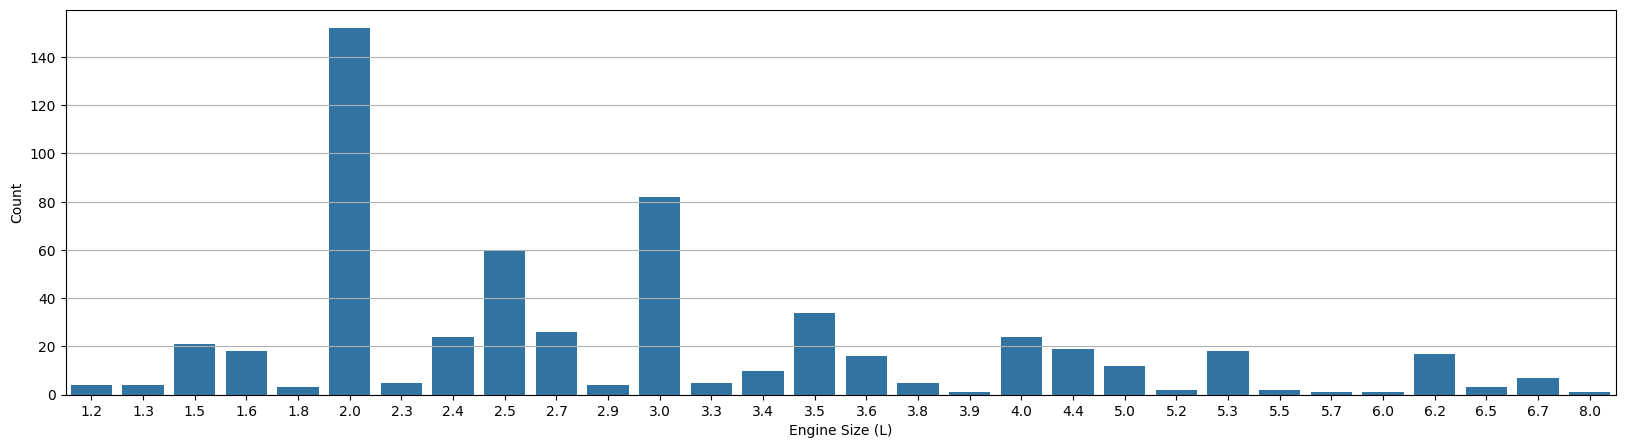

In [36]:
enginesize_counts = df['Engine size (L)'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()
sns.barplot(data=enginesize_counts, x=enginesize_counts['Engine size (L)'], y=enginesize_counts[enginesize_counts.columns[1]])
plt.xlabel('Engine Size (L)')
plt.ylabel('Count')

<Axes: xlabel='Cylinders', ylabel='CO2 emissions (g/km)'>

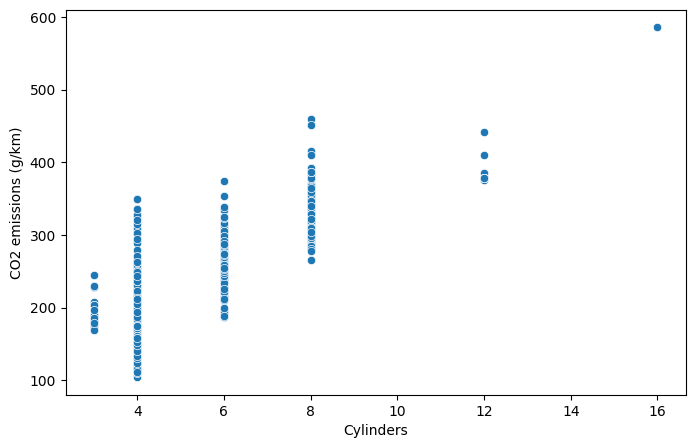

In [37]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Cylinders', y='CO2 emissions (g/km)')

<Axes: xlabel='Engine size (L)', ylabel='CO2 emissions (g/km)'>

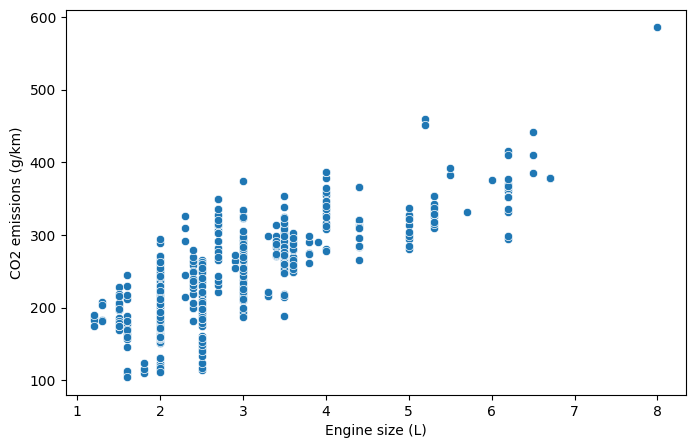

In [38]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Engine size (L)', y='CO2 emissions (g/km)')

The scatter plots show that the emissions correlate with these two features, which makes sense.

## <a id="step_7">Step 7: Fuel Type</a>

In [39]:
df['Fuel type'].unique()

array(['Z', 'X', 'D', 'E'], dtype=object)

As mentioned in the description, the fuel types included are:
- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas

Which means that there is no vehicle powered by natural gas in the dataset

Text(0, 0.5, 'Count')

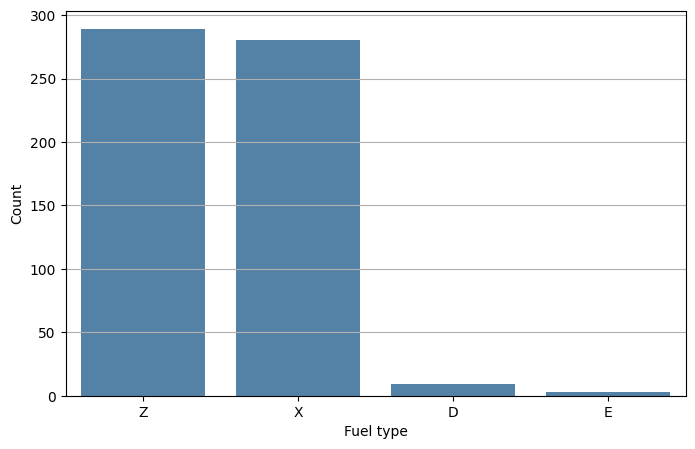

In [40]:
fueltype_counts = df['Fuel type'].value_counts().reset_index(drop=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_counts, x=fueltype_counts['Fuel type'], y=fueltype_counts[fueltype_counts.columns[1]], color='steelblue')
plt.xlabel('Fuel type')
plt.ylabel('Count')

In [41]:
df[df["Fuel type"].str.contains("E|D")]['Make'].value_counts()

Make
Chevrolet    7
GMC          5
Name: count, dtype: int64

There are just a few vehicles powered by Diesel and Ethanol. These are also for the largest part cars made by american car manufacturers like Ford, Chevrolet and GMC. 

<Axes: xlabel='Fuel type', ylabel='CO2 emissions (g/km)'>

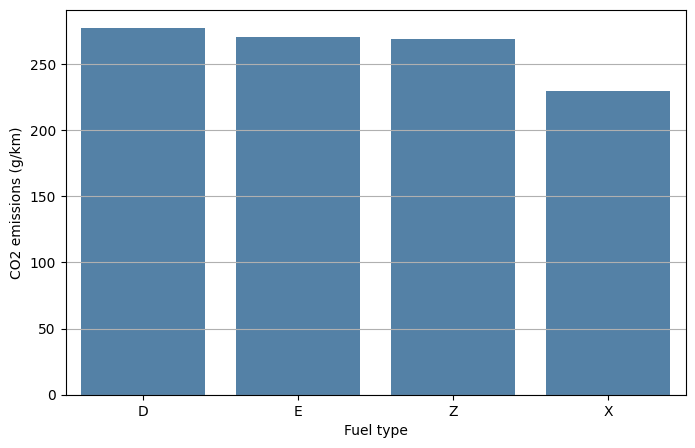

In [42]:
fueltype_CO2 = df.groupby('Fuel type')['CO2 emissions (g/km)'].mean().reset_index(drop=False).sort_values(by='CO2 emissions (g/km)', ascending=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_CO2, x=fueltype_CO2['Fuel type'], y=fueltype_CO2['CO2 emissions (g/km)'], color='steelblue')

Though diesel and ethanol have higher CO2 emissions on average they are not much higher than gasoline.

<Axes: xlabel='Fuel type', ylabel='CO2 emissions (g/km)'>

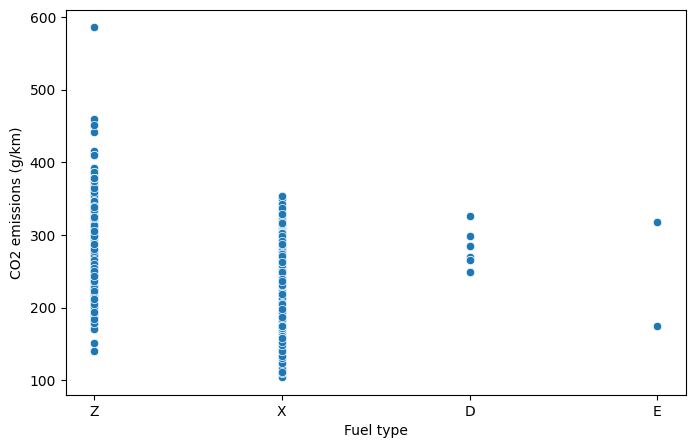

In [43]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Fuel type', y='CO2 emissions (g/km)')

There is a outlier which also drives the average of the premium gasoline vehicles which is the Bugatti seen earlier.

## <a id="step_8">Step 8: Fuel Consumption</a>

<Axes: >

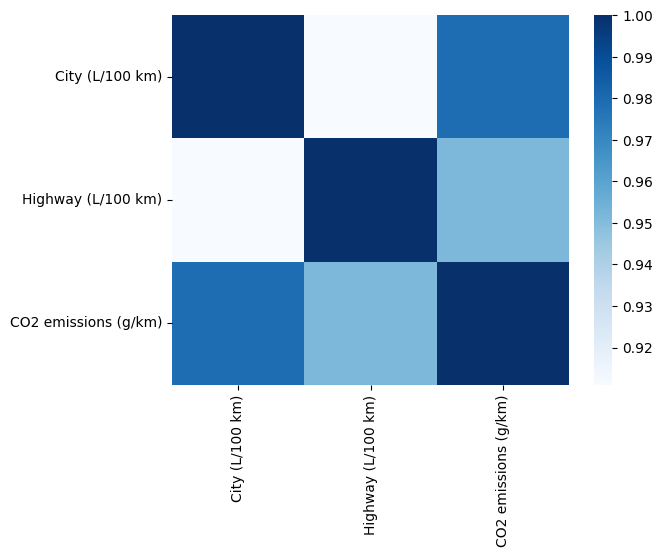

In [44]:
corr = df[['City (L/100 km)', 'Highway (L/100 km)', 'CO2 emissions (g/km)']].corr()
sns.heatmap(corr, cmap="Blues")

For the fuel consumption in the city and on the highway, the fuel consumption in the city has a higher correlation coefficient with the the CO2 emissions than the consumption on the highway. That is probably due to higher efficiency of the vehicles at higher speeds

<Axes: xlabel='City (L/100 km)', ylabel='CO2 emissions (g/km)'>

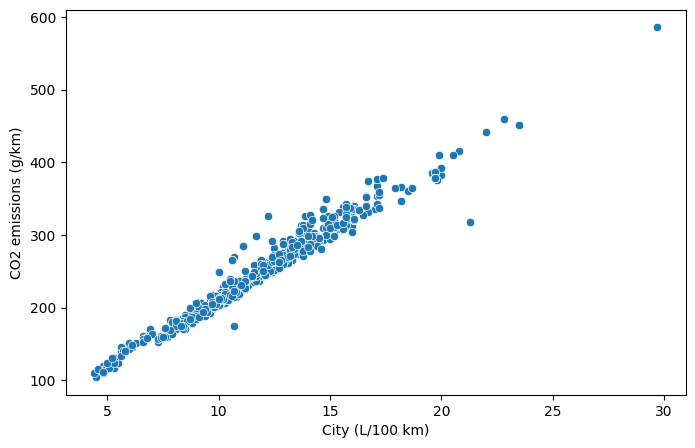

In [45]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='City (L/100 km)', y='CO2 emissions (g/km)')

<Axes: xlabel='Highway (L/100 km)', ylabel='CO2 emissions (g/km)'>

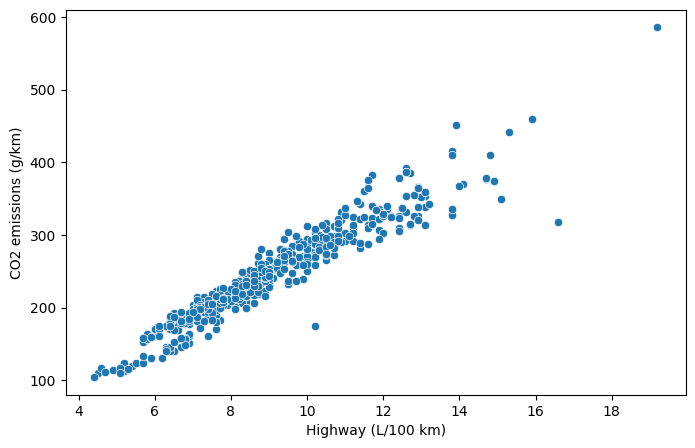

In [46]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Highway (L/100 km)', y='CO2 emissions (g/km)')

<Axes: xlabel='Combined (L/100 km)', ylabel='CO2 emissions (g/km)'>

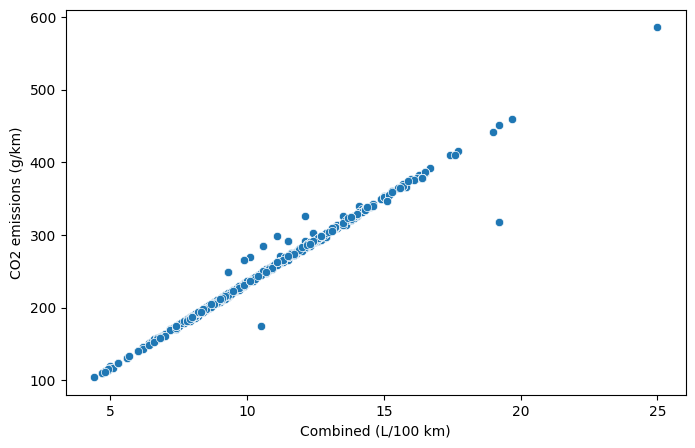

In [47]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Combined (L/100 km)', y='CO2 emissions (g/km)')

As the correlation matrix implies, the scatterplots show the strong relationship of the fuel consumption and the CO2 emissions. However, there are some outliers that distort the graph, as seen in the last graph. Let's check where the points come from. 

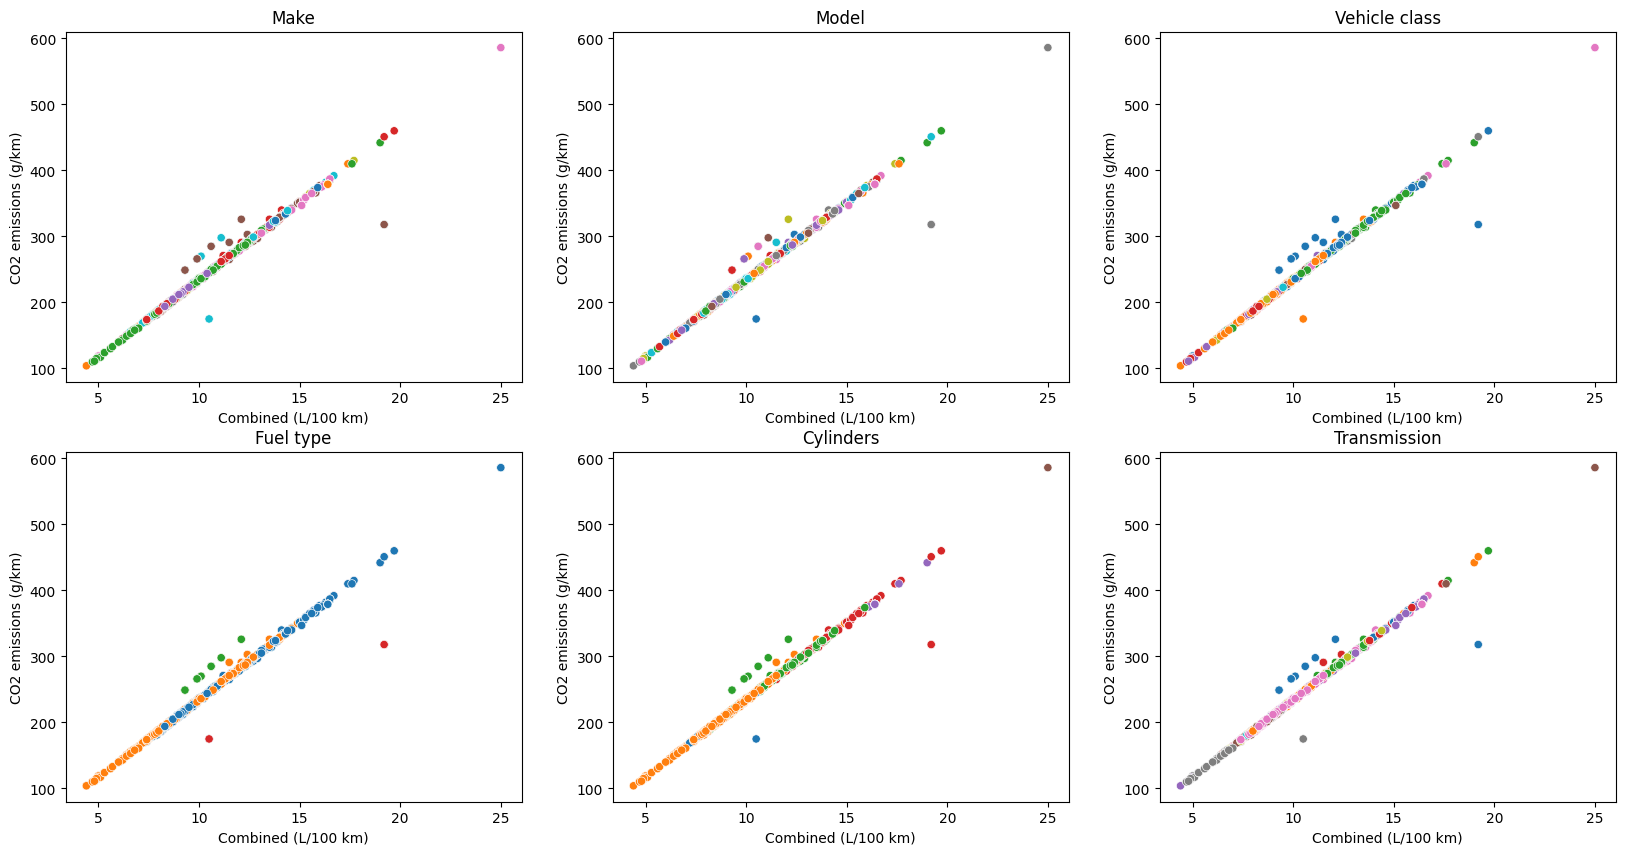

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
cols = ['Make', 'Model', 'Vehicle class', 'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type']
nrow = 0
ncol = 0 
for col in cols:
    if ncol <=2:
        sns.scatterplot(data=df, x='Combined (L/100 km)', y='CO2 emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1
    else:
        nrow = 1
        ncol = 0
        sns.scatterplot(data=df, x='Combined (L/100 km)', y='CO2 emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1

The fuel type and vehicle class show same groups of outliers.

<Axes: xlabel='Combined (L/100 km)', ylabel='CO2 emissions (g/km)'>

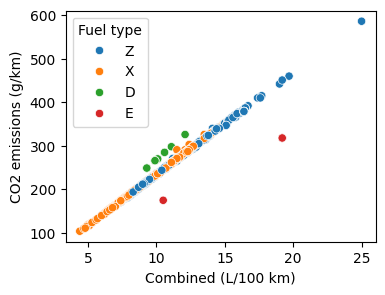

In [49]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df, x='Combined (L/100 km)', y='CO2 emissions (g/km)', hue='Fuel type')

<Axes: xlabel='Combined (L/100 km)', ylabel='CO2 emissions (g/km)'>

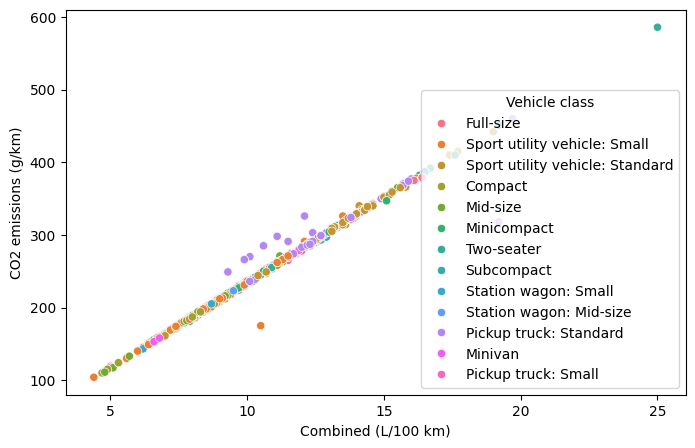

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Combined (L/100 km)', y='CO2 emissions (g/km)', hue='Vehicle class')

So, as expected, the fuel types that form the outliers are the two fuel types, namely ethanol and diesel, that have a comparartively small number of samples. The vehicle classe sshow that there are mostly standard pickup trucks that have higher CO2 emissions as previously shown.

## <a id="step_9">Step 9: Machine Learning</a>

### Data Preprocessing

As shown in Step 2, the dataset contains no missing values that may need to be imputed. Further, the dataset contains no duplicated columns or rows to be deleted or otherwise handled. However, the dataset contains 5 categorical columns that need to be encoded when using machine learning algorithms included in the scikit-learn library as well as a constant column, that does not contain any information an algorithm is able to utilize.

In [51]:
# First, exclude the target variable from the rest of the dataset. Since this dataset has 3 variables that may be used as a target variable for a machine learning algorithm, each will be excluded
X = df.iloc[:,:-3]

In [52]:
# Drop constant columns from the dataset.
print(f'Number of columns before: {len(X.columns)}')
X = X.loc[:, (X != X.iloc[0]).any()]
print(f'Number of columns after: {len(X.columns)}')

Number of columns before: 12
Number of columns after: 11


Then, the categorical columns have to be encoded. There are many encoding strategies that may be used, each with its own advantages and disadvantages. We first will try a very straight forwared encoding strategy called ordinal encoding. Here, every unique value in a categorical column will be assigned a integer that replaces the categorical value. The numbers typically start with 0 or 1 and increment for each additinal unique value in the column. Downside to using this strategy is the implementation of an order of the resulting numerical values.

In [53]:
ordinal_encoder = OrdinalEncoder(return_df=True)
print('Number of categorical columns before:', (X.dtypes == 'object').sum())
X_ordinal_encoded = ordinal_encoder.fit_transform(X)
print('Number of categorical columns after:', (X_ordinal_encoded.dtypes == 'object').sum())

Number of categorical columns before: 5
Number of categorical columns after: 0


Further, we can use a scaler to rescale the columns in the dataset so all columns are on the same scale as well as normalize the columns in the dataset so the distribution in the columns closely resemble a normal distribution instead of being skewed.

In [54]:
standard_scaler = StandardScaler()

cols_before = X_ordinal_encoded.columns
X_ordinal_encoded = pd.DataFrame(data=standard_scaler.fit_transform(X_ordinal_encoded), columns = cols_before)

In [55]:
cols_before = X_ordinal_encoded.columns
X_ordinal_encoded = pd.DataFrame(data=power_transform(X_ordinal_encoded, method='yeo-johnson'), columns = cols_before)

##### Let's use the CO2 emissions as the target variable, which is a continuous variable, resulting in the use of regression models

In [56]:
# Specify target variable
y = df['CO2 emissions (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded, y, test_size=0.3)

DecisionTree

In [57]:
decisiontree_model_regression = DecisionTreeRegressor()

decisiontree_model_regression.fit(X_train, y_train)
cvs = -cross_val_score(decisiontree_model_regression, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print(f'Cross Validation RMSE Score: {cvs}')

y_pred = decisiontree_model_regression.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
max_e = max_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Max Error: {max_e}')

Cross Validation RMSE Score: 13.938856577544357
Root Mean Squared Error: 4.922833098357664
Mean Squared Error: 24.234285714285715
Mean Absolute Error: 2.4285714285714284
Max Error: 35.0


RandomForest

In [58]:
randomforest_model_regression = RandomForestRegressor()

randomforest_model_regression.fit(X_train, y_train)
cvs = -cross_val_score(randomforest_model_regression, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print(f'Cross Validation RMSE Score: {cvs}')

y_pred = randomforest_model_regression.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
max_e = max_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Max Error: {max_e}')

Cross Validation RMSE Score: 12.761047249995034
Root Mean Squared Error: 6.064414469439144
Mean Squared Error: 36.77712285714286
Mean Absolute Error: 2.3585714285714285
Max Error: 69.75999999999999


The closer the Error to 0, the better, with a perfect score when an error of 0 is achieved. So the RMSE and MAE show already very good results. Let's check the scores for a classification task.

##### Let's use the CO2 rating as the target variable, which is a discrete variable, resulting in the use of classification models

In [59]:
# Specify target variable
y = df['CO2 rating']
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded, y, test_size=0.3, stratify=y)

In [60]:
df['CO2 rating'].unique()

array([6, 5, 4, 3, 2, 1, 7, 8])

Since the CO2 Rating has more than two classes and we therefore need a multiclass prediction model, we need to set a parameter for the scoring metrics. Here we set the average parameter to 'macro', so the metrics are calculated for each class and then an unweighted mean is identified. This method is highly sensitive to unbalanced data, which the CO2 Rating is, as shown in Step 3

DecisionTree

In [61]:
decisiontree_model_classification = DecisionTreeClassifier()

decisiontree_model_classification.fit(X_train, y_train)
cvs = cross_val_score(decisiontree_model_classification, X_train, y_train, cv = 5, scoring = 'f1_macro').mean()
print(f'Cross Validation F1 Score: {cvs}')

y_pred = decisiontree_model_classification.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Cross Validation F1 Score: 0.9797216312957474
Accuracy: 0.9485714285714286
Precision: 0.9659711998527788
Recall: 0.932217261904762
F1 Score: 0.9464305410865044


RandomForest

In [62]:
randomforest_model_classification = RandomForestClassifier()

randomforest_model_classification.fit(X_train, y_train)
cvs = cross_val_score(randomforest_model_classification, X_train, y_train, cv = 5, scoring = 'f1_macro').mean()
print(f'Cross Validation F1 Score: {cvs}')

y_pred = randomforest_model_classification.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Cross Validation F1 Score: 0.9821165116616868
Accuracy: 0.96
Precision: 0.9656133286647992
Recall: 0.8941964285714286
F1 Score: 0.9188602029062556


The resulting test scores show already very good results. However, the RandomForest model shows that the training scores are lower than the test scores, so we might expect the model to underfit the data. Let's try different parameter settings for the RandomForest model.

In [63]:
randomforest_model_classification = RandomForestClassifier()

grid = {'n_estimators': randint.rvs(50, 400, size=10),
        'min_samples_leaf' : randint.rvs(1, 12, size=10),
        'min_samples_split' : randint.rvs(2, 10, size=10)}
randomforest_rscv = RandomizedSearchCV(randomforest_model_classification, param_distributions=grid, scoring='f1_macro', cv=5)

randomforest_rscv.fit(X_train, y_train)

print(randomforest_rscv.best_params_)
print(randomforest_rscv.best_score_)

{'n_estimators': np.int64(250), 'min_samples_split': np.int64(7), 'min_samples_leaf': np.int64(3)}
0.9341565796118898
